## The dynamics of the adaptive exponential Integrate-and-Fire model

### Author: Hannes Erbis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelmax, argrelmin
import os
from parameters import get_params

In [2]:
def model(V, w, params):
    '''
    Adapative exponential integrate-and-fire model (AdEx)
    :param V: membrane potential
    :param w: adaptation term
    :param params: model parameters
    :return: differential equations dV_dt, dw_dt
    '''

    dV_dt =  (-params['g_L'] * (V - params['E_L']) + params['g_L'] * params['delta_T'] * np.exp((V - params['V_T'])/params['delta_T']) - w + params['I']) / params['C']
    dw_dt =  (params['a'] * (V - params['E_L']) - w) / params['tau_w']

    return dV_dt, dw_dt

In [3]:
def solve_model(time_span, initial_values, params, dt=0.01,
                current_mode = 'constant', t_current_start=0, t_current_end=30000, pulse_duration=5, rest_duration=50):
    '''
    Solves the differential equation model using Eulers method.

    :param time_span: over which time span the model should be integrated
    :param initial_values: initial values, V0, w0 in the form [V0, w0]
    :param params: model parameters
    :param dt: integration step size
    :param current_mode: how the current should be applied. Possible scenarios:
            'constant': the current is applied constantly at the same rate given by the 'I' value in params
            'pulse' : the current is pulsing according to the pulse_duration and rest_duration up to a value specified by 'I' in params
    :param t_current_start: when the current starts being applied. defaults to 0
    :param t_current_end: when the current stops being applied
    :param pulse_duration: how long a current pulse spike should be maintained each time. only relevant if current_mode = 'pulse'
    :param rest_duration: how long the current should be set to 0 after a pulse spike. only relevant if current_mode = 'pulse'
    :return: t_values, solved x and solved y and the applied current over the given time frame
    '''

    t_values = np.arange(time_span[0], time_span[1], dt)
    x = np.zeros(len(t_values))
    y = np.zeros(len(t_values))

    x[0] = initial_values[0]
    y[0] = initial_values[1]

    current = create_current(t_values, params, current_mode, t_current_start, t_current_end, pulse_duration, rest_duration)
    spike_times = []

    for i in range(1, len(t_values)):
        params['I'] = current[i]
        if x[i-1] > params['V_thresh']:
            spike_times.append(t_values[i])
            x[i-1] = params['V_thresh']
            x[i] = params['V_reset']
            y[i] = y[i-1] + params['b']
        else:
            x[i] = x[i-1] + model(x[i-1], y[i-1], params)[0] * dt #Eulers method
            y[i] = y[i-1] + model(x[i-1], y[i-1], params)[1] * dt #Eulers method


    return t_values, x, y, current, spike_times #Return t values, solved value, current values and times of spikes

def create_current(t_values, params,
                   mode = 'constant', t_current_start=None, t_current_end=None, pulse_duration=None, rest_duration=None):
    '''
    Creates the current that should be applied given the stated specifications
    :param t_values: the time values for which we need to determine the current
    :param params: model parameters
    :param current_mode: how the current should be applied. Possible scenarios:
            'constant': the current is applied constantly at the same rate given by the 'I' value in params
            'pulse' : the current is pulsing according to the pulse_duration and rest_duration up to a value specified by 'I' in params
    :param t_current_start: when the current starts being applied. defaults to 0
    :param t_current_end: when the current stops being applied
    :param pulse_duration: how long a current pulse spike should be maintained each time. only relevant if current_mode = 'pulse'
    :param rest_duration: how long the current should be set to 0 after a pulse spike. only relevant if current_mode = 'pulse'
    :return: applied current over the given time
    '''

    current = []
    if mode == 'pulse':
        for t in t_values:
            if t % (pulse_duration + rest_duration) < rest_duration:
                current.append(0)
            else:
                current.append(params['I'])

    if mode == 'constant':
        if t_current_start is not None and t_current_end is not None and t_current_start > 0:
            for t in t_values:
                if t>t_current_start and t<t_current_end:
                    current.append(params['I'])
                else:
                    current.append(0)
        else:
            for t in t_values:
                current.append(params['I'])

    return current

In [4]:
def plot_trajectory(time_span, initial_values, params, dt=0.01,
                    current_mode = 'constant', t_current_start=0, t_current_end=30000, pulse_duration=5, rest_duration=50):
    '''
    Solves the model and plots (without calling plt.show()) the trajectory on the V-w plane
    :param time_span: over which time span the model should be integrated
    :param initial_values: initial values, V0, w0 in the form [V0, w0]
    :param params: model parameters
    :param dt: integration step size
    :param current_mode: how the current should be applied. Possible scenarios:
            'constant': the current is applied constantly at the same rate given by the 'I' value in params
            'pulse' : the current is pulsing according to the pulse_duration and rest_duration up to a value specified by 'I' in params
    :param t_current_start: when the current starts being applied. defaults to 0
    :param t_current_end: when the current stops being applied
    :param pulse_duration: how long a current pulse spike should be maintained each time. only relevant if current_mode = 'pulse'
    :param rest_duration: how long the current should be set to 0 after a pulse spike. only relevant if current_mode = 'pulse'
    '''

    solved = solve_model(time_span, initial_values, params, dt, current_mode, t_current_start, t_current_end, pulse_duration, rest_duration)

    solved_x_transient = solved[1][:int(len(solved[1])/3)]
    solved_y_transient = solved[2][:int(len(solved[2])/3)]
    solved_x_without_transient = solved[1][int(len(solved[1])/3):]
    solved_y_without_transient = solved[2][int(len(solved[1])/3):]

    plt.plot(solved_x_transient, solved_y_transient, color='lime', linewidth=2.5, linestyle='--')
    plt.plot(solved_x_without_transient, solved_y_without_transient, color='lime', linewidth=2.5, linestyle='--')


def plot_nullclines(x, y, params):
    '''
    Calculates and plots (without calling plt.show()) the nullclines for both variables
    :param x: V range
    :param y: w range
    :param params: model parameters
    '''

    V_nullcline = np.zeros((len(x), len(y)))
    w_nullcline = np.zeros((len(x), len(y)))

    for i, x_ in enumerate(x):
        for j, y_ in enumerate(y):
            x__, y__ = model(x_, y_, params)
            V_nullcline[j, i] = x__
            w_nullcline[j, i] = y__

    V_nullcl_contour = plt.contour(x, y, V_nullcline, levels=[0], colors='red', linewidths=3.5)
    w_nullcl_contour = plt.contour(x, y, w_nullcline, levels=[0], colors='blue', linewidths=3.5)
    return V_nullcl_contour, w_nullcl_contour


def plot_vectorfield(x, y, params):
    '''
    Plots the vectorfield (without calling plt.show()). NOT USED IN PROJECT
    :param params: model parameters
    :param x: V values
    :param y: w values
    '''
    evals = 30
    x = np.linspace(x[0], x[-1], evals)
    y = np.linspace(y[0], y[-1], evals)
    x_, y_ = np.meshgrid(x, y)
    Dx_, Dy_ = model(x_, y_, params)
    M = (np.hypot(Dx_, Dy_))
    Dx_ /= M
    Dy_ /= M

    plt.quiver(x_, y_, Dx_, Dy_, M, pivot='mid', color='black')


def plot_equilibria(V_nullcl_contour, w_nullcl_contour, eps=0.01):
    V_nullclines = V_nullcl_contour.collections[0].get_paths()[0].vertices
    w_nullclines = w_nullcl_contour.collections[0].get_paths()[0].vertices
    equilibria = []
    for i, V_ in enumerate(V_nullclines):
        for j, w_ in enumerate(w_nullclines):
            diff1 = V_[0] / w_[0]
            diff2 = V_[1] / w_[1]

            if diff1 < 1 + eps and diff1 > 1 - eps and diff2 < 1 + eps and diff2 > 1 - eps and diff1 > 0 and diff2 > 0:
                equilibria.append([V_[0], V_[1]])
    equilibria = np.array(equilibria)
    if len(equilibria) > 0 :
        plt.scatter(equilibria[:,0], equilibria[:,1], s=60, color='black', zorder=8)


def plot_phase_portrait(x, y, params, time_span, trajectories=[], dt=0.01,
                        current_mode = 'constant', t_current_start=0, t_current_end=30000, pulse_duration=5, rest_duration=50, savefig=False):
    '''
    Plots the phase plane including nullclines, trajectories and equilibria
    :param x: V values
    :param y: w values
    :param params: model parameters
    :param time_span:
    :param trajectories: initial values for trajectories in the form [[V0_1, w0_1], [V0_2, w0_2], ...]
    :param current_mode: how the current should be applied. Possible scenarios:
            'constant': the current is applied constantly at the same rate given by the 'I' value in params
            'pulse' : the current is pulsing according to the pulse_duration and rest_duration up to a value specified by 'I' in params
    :param t_current_start: when the current starts being applied. defaults to 0
    :param t_current_end: when the current stops being applied
    :param pulse_duration: how long a current pulse spike should be maintained each time. only relevant if current_mode = 'pulse'
    :param rest_duration: how long the current should be set to 0 after a pulse spike. only relevant if current_mode = 'pulse'
    '''

    #Plots the phase plate.
    #This includes nullclines, equilibria, vectorfield and optionally (for question 2) trajectories
    if trajectories == 'random':
        trajectories =[]
        for i in range(3):
            trajectories.append([np.random.randint(-80, -40), np.random.randint(-300, 300)])

    plt.figure(dpi=140, figsize=[7,7])

    #Plot Nullclines
    V_nullcl, w_nullcl = plot_nullclines(x, y, params)

    #--------------------------------------------------------------------------------------
    #Plot equilibria
    plot_equilibria(V_nullcl, w_nullcl)

    #--------------------------------------------------------------------------------------
    #Plot vectorfield
    plot_vectorfield(x, y, params)


    #--------------------------------------------------------------------------------------
    #Plot trajectories
    for trajectory in trajectories:
        plot_trajectory(time_span, trajectory, params, dt, current_mode, t_current_start, t_current_end, pulse_duration, rest_duration)

    plt.ylim(y[0], y[-1])
    plt.xlim(x[0], x[-1])

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('$V [mV]$', fontsize=18)
    plt.ylabel('$w [nA]$', fontsize=18)
    plt.title(f"Input current, $I = {params['I']} \ pA$", fontsize=16)
    red_patch = plt.Line2D([], [], color='red', label='V nullcline')
    blue_patch = plt.Line2D([], [], color='blue', label='w nullcline')
    lime_patch = plt.Line2D([], [], color='lime', label='trajectory')
    plt.legend(handles=[red_patch, blue_patch, lime_patch], fancybox=False, framealpha=1, facecolor='linen')
    plt.tight_layout()
    if savefig:
        save_fig("phase", params)

    else:
        plt.show()


def plot_time_series(time_span, initial_values, params, dt=0.01,
                     current_mode = 'constant', t_current_start=0, t_current_end=30000, pulse_duration=5, rest_duration=50, savefig = False):
    '''
    Plots how the membrane potential evolves over time
    :param time_span: over which time span the model should be integrated
    :param initial_values: initial values in the form [[V0_1, w0_1], [V0_2, w0_2], ...]
    :param params: model parameters
    :param current_mode: how the current should be applied. Possible scenarios:
            'constant': the current is applied constantly at the same rate given by the 'I' value in params
            'pulse' : the current is pulsing according to the pulse_duration and rest_duration up to a value specified by 'I' in params
    :param t_current_start: when the current starts being applied. defaults to 0
    :param t_current_end: when the current stops being applied
    :param pulse_duration: how long a current pulse spike should be maintained each time. only relevant if current_mode = 'pulse'
    :param rest_duration: how long the current should be set to 0 after a pulse spike. only relevant if current_mode = 'pulse'
    '''

    for init in initial_values:
        solved = solve_model(time_span, init, params, dt, current_mode, t_current_start, t_current_end, pulse_duration, rest_duration)

        plt.figure(dpi=150, figsize=[10, 5])
        plt.plot(solved[0], solved[1], color='black', linewidth=1.5)
        plt.xlabel('Time, $t$, in ms', fontsize=14)
        plt.ylabel('$V [mV]$', fontsize=14)
        plt.ylim(-73, 23)

        if savefig:
            save_fig("timeseries_V", params)
        else:
            plt.show()


        plt.figure(dpi=150, figsize=[10, 5])
        plt.plot(solved[0], solved[2], color='red',linewidth=3)
        plt.xlabel('Time, $t$, in ms', fontsize=14)
        plt.ylabel('$w [nA]$', fontsize=14)
        plt.ylim(-5, 500)

        if savefig:
            save_fig("timeseries_w", params)
        else:
            plt.show()

        # plt.figure(dpi=100, figsize=[10, 5])
        # plt.plot(solved[0], solved[3], color='red',linewidth=3)
        # plt.xlabel('Time, $t$, in ms', fontsize=14)
        # plt.ylabel('Current (pA)', fontsize=14)
        # plt.tight_layout()



def plot_bifurcation_diagram(bifurcation_parameter, bifurcation_values, time_span, initial_values, params, dt=0.01,
                             current_mode = 'constant', t_current_start=0, t_current_end=30000, pulse_duration=5, rest_duration=50,
                             xlim=[-200, 800], sequential_plot = False, savefig=False, showfig=True):
    '''
    Plots the bifurcation diagram with the given bifurcation porameter
    :param bifurcation_parameter: parameter for which we plot the bifurcation diagram for
    :param bifurcation_values: values of the bifurcation diagram that should bne considered
    :param time_span: over which time span the model should be integrated
    :param initial_values: initial values, V0, w0 in the form [[V0_1, w0_1], [V0_2, w0_2], ...]
    :param params: model parameters
    :param dt: integration step size
    :param current_mode: how the current should be applied. Possible scenarios:
            'constant': the current is applied constantly at the same rate given by the 'I' value in params
            'pulse' : the current is pulsing according to the pulse_duration and rest_duration up to a value specified by 'I' in params
    :param t_current_start: when the current starts being applied. defaults to 0
    :param t_current_end: when the current stops being applied
    :param pulse_duration: how long a current pulse spike should be maintained each time. only relevant if current_mode = 'pulse'
    :param rest_duration: how long the current should be set to 0 after a pulse spike. only relevant if current_mode = 'pulse'
    :param xlim: x limits for plot
    :param sequential_plot: whether the plot should be plotted for each single bifurcation value at a time
    :param savefig: whether or not the plot should be saved
    :param showfig: whether or not the plot should be shown
    '''

    results_bif = []
    results_y = []
    for param in bifurcation_values:
        params[bifurcation_parameter] = param
        solved = solve_model(time_span, initial_values[0], params, dt, current_mode, t_current_start, t_current_end, pulse_duration, rest_duration)
        time_series = solved[2][-int(len(solved[2]) * 40 / 100):]
        time_series_V = solved[1][-int(len(solved[1]) * 40 / 100):]
        maximum = np.max(time_series_V)
        arg_local_maxima = argrelmax(time_series_V)[0]
        local_maxima = time_series[arg_local_maxima]

        result = np.hstack((maximum, local_maxima))

        for r in result:
            results_bif.append(param)
            if np.max(time_series_V) > params['V_thresh']*0.99:
                results_y.append(r)
            else:
                results_y.append(-1000)
    if showfig:
        if sequential_plot:
            for bifurcation_value in bifurcation_values:
                plt.figure(dpi=130, figsize=[10, 7])
                plot_indices = np.argwhere(results_bif <= bifurcation_value)
                plt.plot(np.array(results_bif)[plot_indices], np.array(results_y)[plot_indices], 'k.', markersize=4)

                plt.xlabel(f"{bifurcation_parameter}", fontsize=18)
                plt.ylabel("$w$", fontsize=18)
                plt.ylim(100,600)
                plt.tight_layout()
                plt.xlim(xlim[0]-np.abs(xlim[0])*0.001, xlim[1]+np.abs(xlim[0])*0.001)
                if savefig:
                    save_fig('bifurcation', params)
                plt.show()

        else:
            if showfig:
                plt.figure(dpi=130, figsize=[10, 7])
                plt.plot(results_bif, results_y, 'k.', markersize=4)

                plt.xlabel(f"{bifurcation_parameter}", fontsize=18)
                plt.ylabel("$w [nA]$", fontsize=18)
                plt.ylim(50,600)
                plt.tight_layout()
                plt.xlim(xlim[0]-np.abs(xlim[0])*0.001, xlim[1]+np.abs(xlim[0])*0.001)
                if savefig:
                    save_fig('bifurcation', params)
                plt.show()
    else:
        return results_bif, results_y


def save_fig(plot_type, params):
    '''
    Saves the figure under the name 'plot_time_X_params[I]_params['V_rest'].png' in the current folder
    :param plot_type: bifurcation, phase_portrait,...
    :param params: model parameters
    '''

    I = params['I']
    V_reset = np.round(params['V_reset'],1)
    existing_files = [filename for filename in os.listdir('figures') if filename.startswith(plot_type)]
    figure_count = len(existing_files) + 1
    file_name =  f'figures/{plot_type}_{figure_count}_I{I}_Vreset{V_reset}.png'
    plt.savefig(file_name)

def test_for_chaos(time_span, initial_values, params, dt=0.05):
    '''
    Calculates the amount of unique w values at spike times over the given time_span
    :param time_span: over which time span the model should be integrated
    :param initial_values: initial values, V0, w0 in the form [[V0_1, w0_1], [V0_2, w0_2], ...]
    :param params: model parameters
    :param dt: integration step size
    :param current_mode: how the current should be applied. Possible scenarios:
            'constant': the current is applied constantly at the same rate given by the 'I' value in params
            'pulse' : the current is pulsing according to the pulse_duration and rest_duration up to a value specified by 'I' in params
    :param t_current_start: when the current starts being applied. defaults to 0
    :param t_current_end: when the current stops being applied
    :param pulse_duration: how long a current pulse spike should be maintained each time. only relevant if current_mode = 'pulse'
    :param rest_duration: how long the current should be set to 0 after a pulse spike. only relevant if current_mode = 'pulse'
    :return: amount of unique w values at spike times over the given time_span
    '''

    bifurcation_parameter = 'none'
    bifurcation_values = [0]
    _, results_y = plot_bifurcation_diagram(bifurcation_parameter, bifurcation_values, time_span, initial_values, params, dt, showfig=False)
    result = len(np.unique(np.round(results_y,0)))
    return result


In [5]:
def two_dimensional_chaos(time_span, initial_values, params, I_values_2d, V_reset_values_2d):
    '''
    Tests the system for chaos for all combinations of the given I and V_reset values and plots the resulting plane
    :param time_span: over which time span the model should be integrated
    :param initial_values: initial values, V0, w0 in the form [[V0_1, w0_1], [V0_2, w0_2], ...]
    :param params: model parameters
    :param I_values_2d: array which contains all I values that need to be tested
    :param V_reset_values_2d: array which contains all V_reset values that need to be tested
    :return: return the amount of unique w unique values at spike times over t
    '''

    I_V_reset_plane = np.zeros([len(I_values_2d), len(V_reset_values_2d)])
    for i, I in enumerate(I_values_2d):
        for j, V_reset in enumerate(V_reset_values_2d):
            params['I'] = I
            params['V_reset'] = V_reset

            result = test_for_chaos(time_span, initial_values, params)
            I_V_reset_plane[i][j] = result

    fig, ax = plt.subplots(figsize=(7,7),dpi=300)
    im = ax.imshow(I_V_reset_plane, cmap="hot", extent=[V_reset_values_2d[0],V_reset_values_2d[-1], I_values_2d[0],I_values_2d[-1]], aspect='auto', origin='lower')
    ax.set_ylabel("$I [nA]$",fontsize=22)
    ax.set_xlabel("$V_{reset} [mV]$",fontsize=22)
    clb = fig.colorbar(im)
    clb.ax.set_title('Number of unique\n$w$-values at spike', fontsize=13)
    fig.tight_layout()


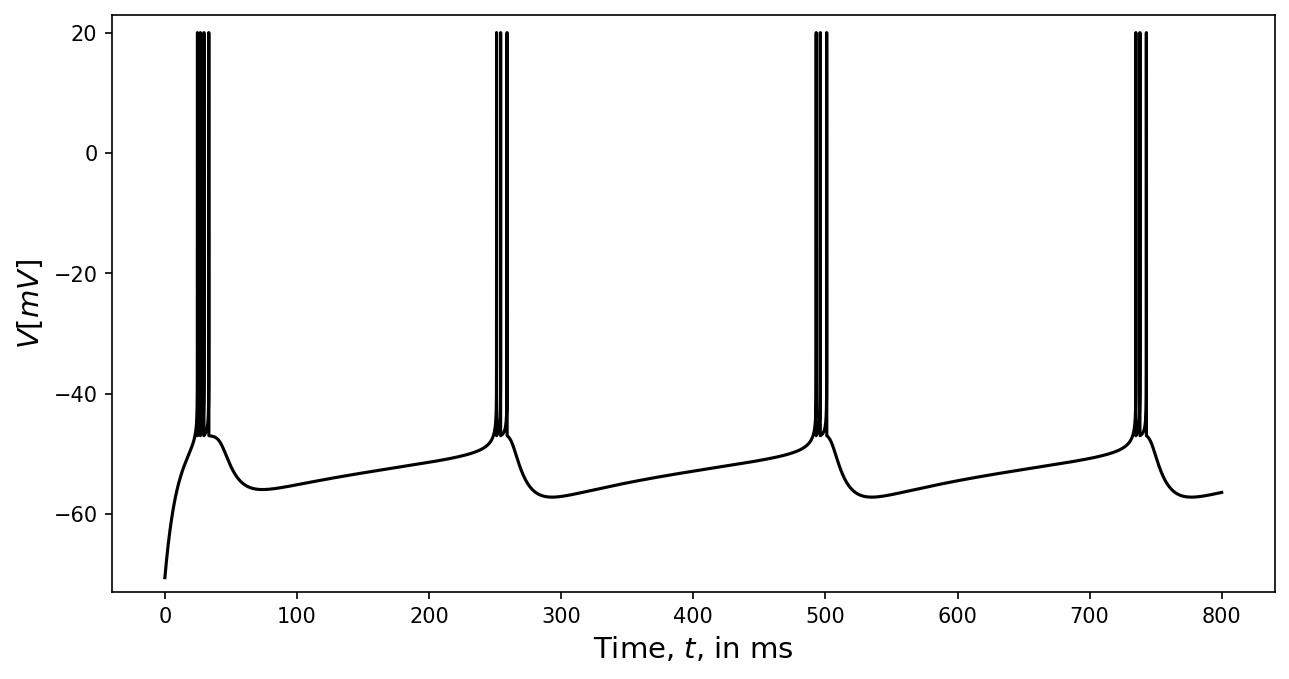

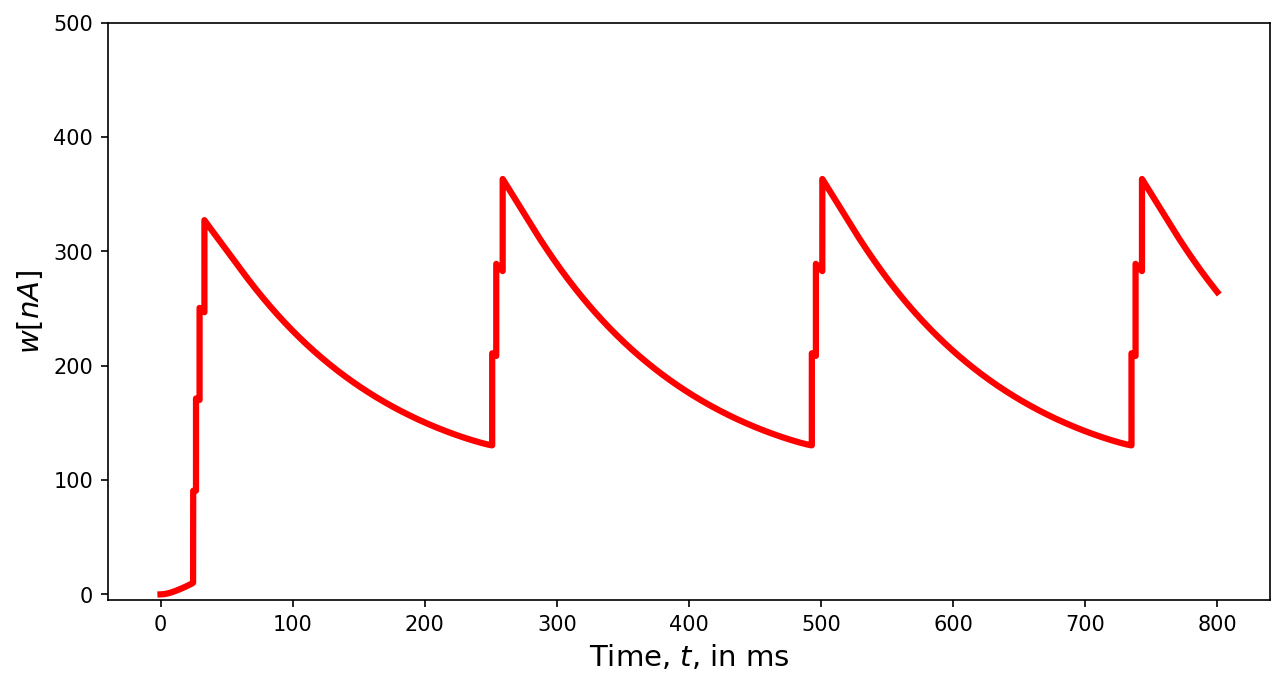

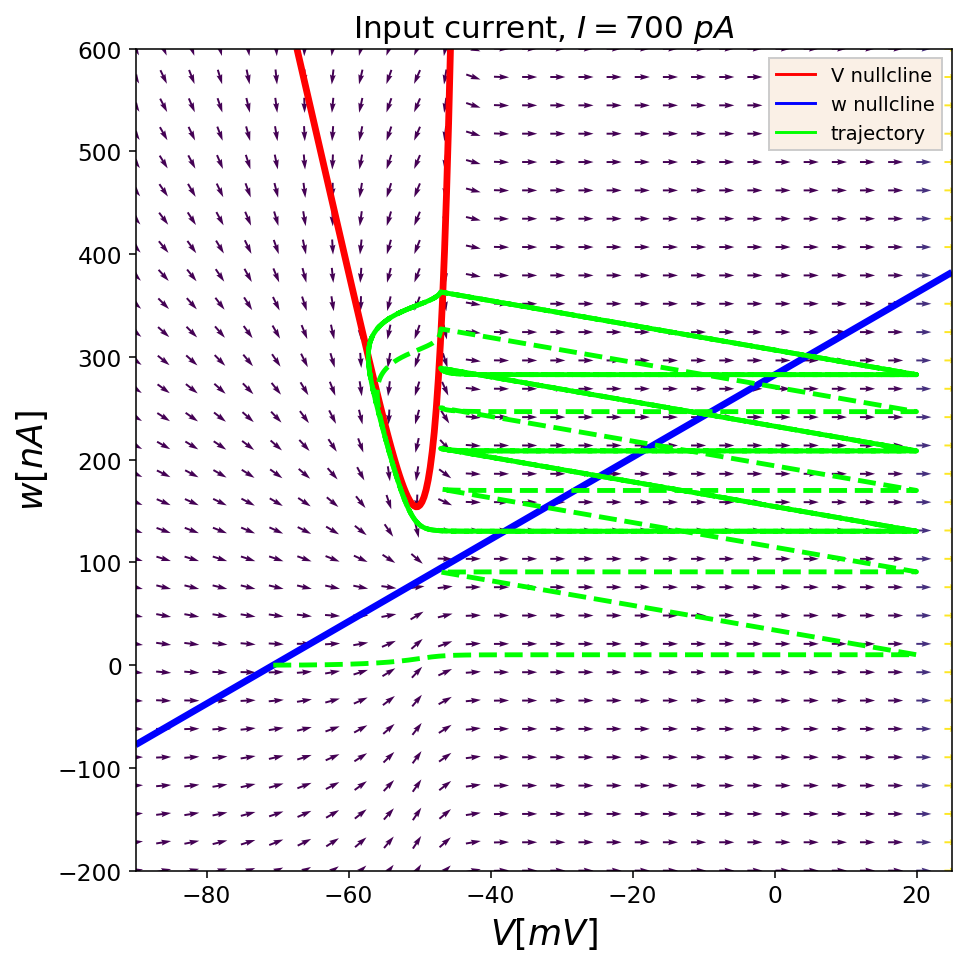

In [6]:
#Testing
#Bursting
V_values = np.linspace(-90, 25, 400)
w_values = np.linspace(-200, 600, 400)
time_span = [0,  800]


params = get_params('continued bursting')
initial_values = [[params['E_L'], 0]]

plot_time_series(time_span, initial_values, params, savefig=False)
plot_phase_portrait(V_values, w_values, params, time_span, trajectories=initial_values, savefig=False)


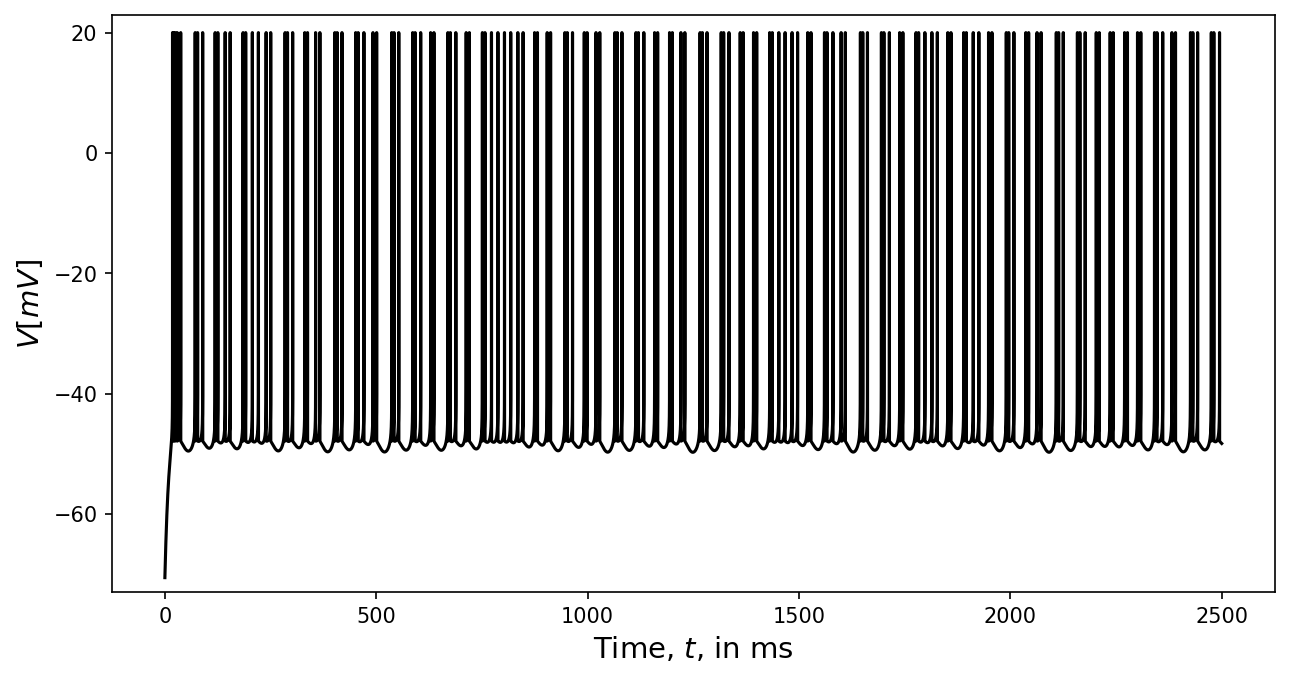

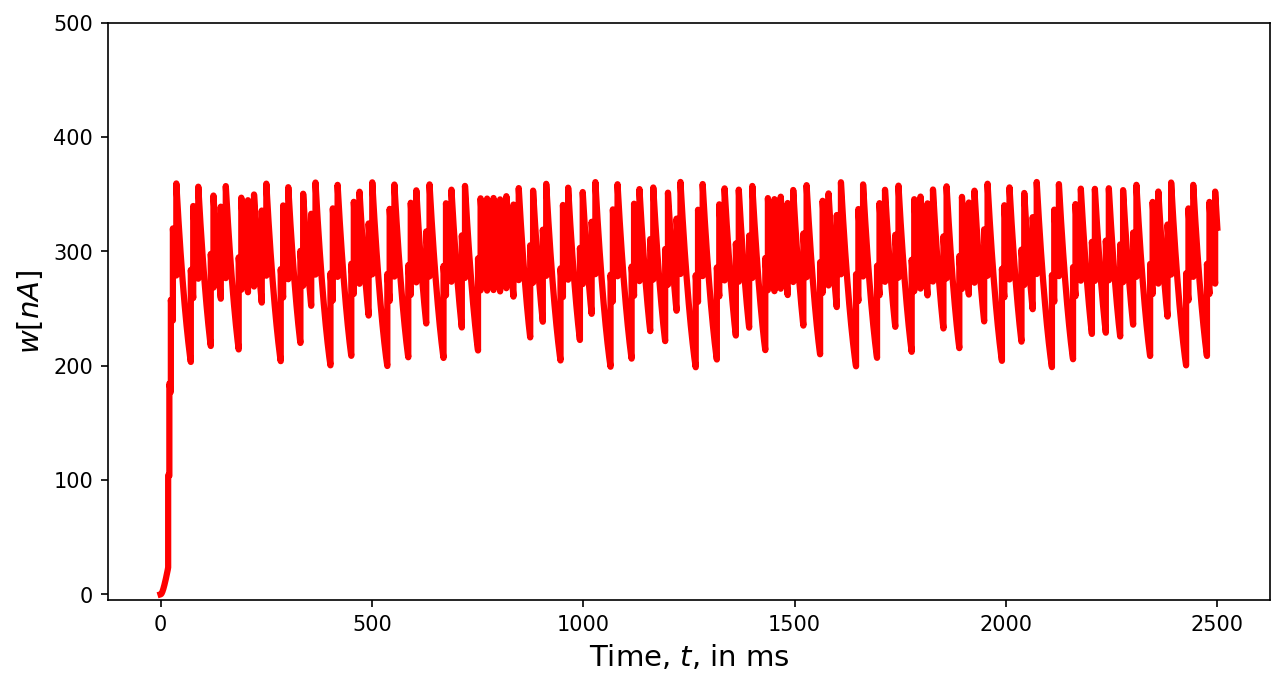

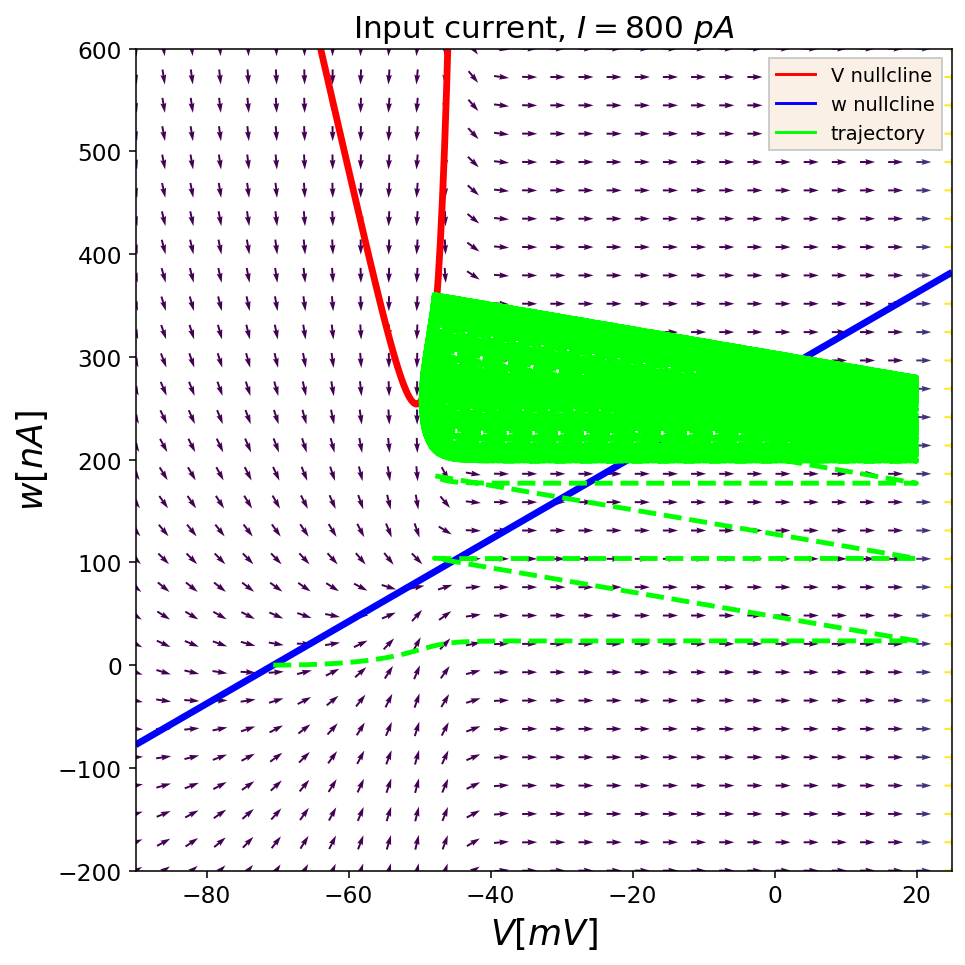

In [7]:
#Chaos
time_span=[0, 2500]
params = get_params('chaos')
initial_values = [[params['E_L'], 0]]

plot_time_series(time_span, initial_values, params, savefig=False)
plot_phase_portrait(V_values, w_values, params, time_span, trajectories=initial_values, savefig=False)


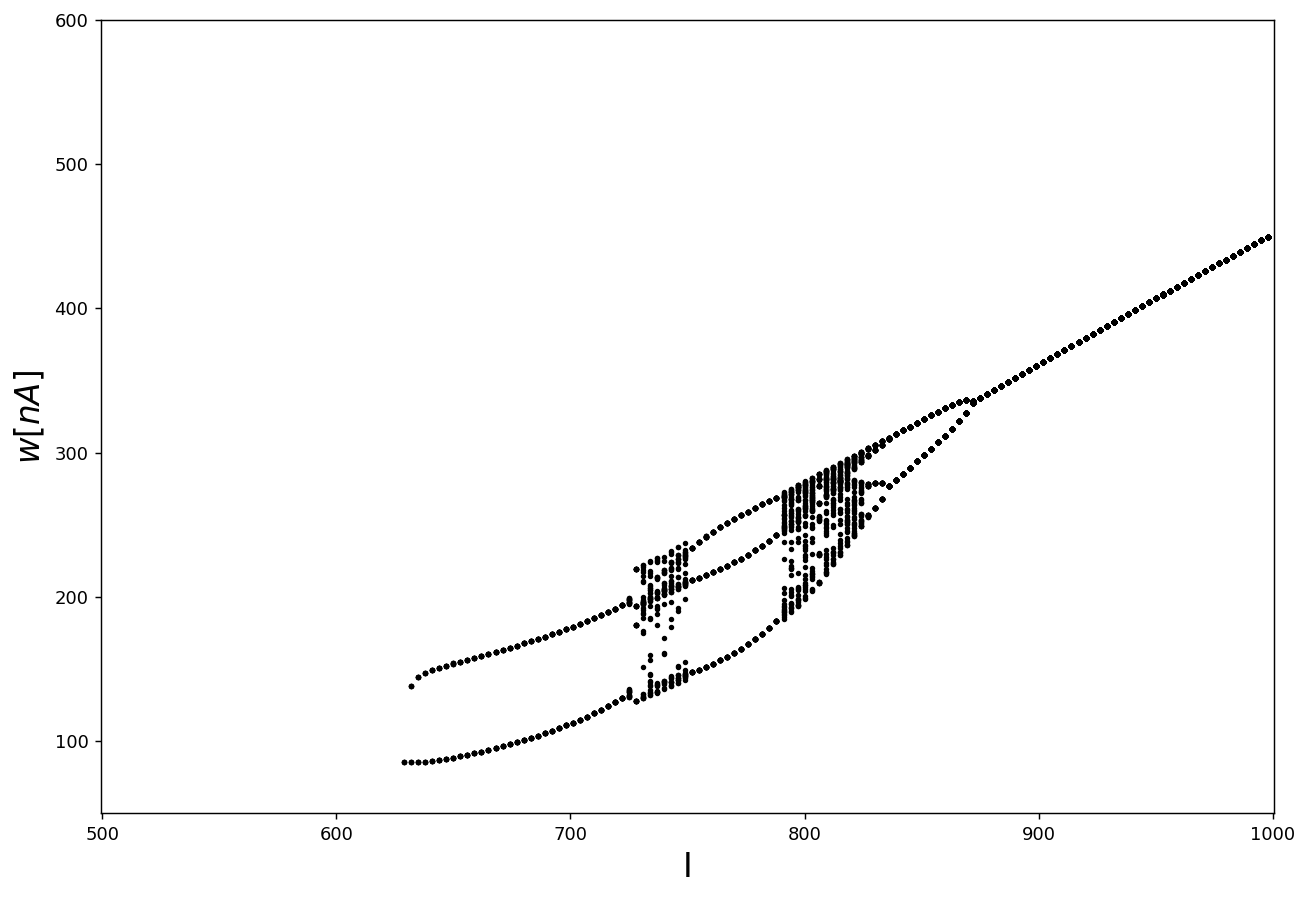

In [8]:
#I bifurcation diagram
#WARNING: LOW RESOLUTION
I_value_range = [500, 1000]
I_values = np.arange(I_value_range[0], I_value_range[1], 3)
bifurcation_parameter = 'I'
bifurcation_values = I_values
plot_bifurcation_diagram(bifurcation_parameter, bifurcation_values, time_span, initial_values, params, xlim=I_value_range)

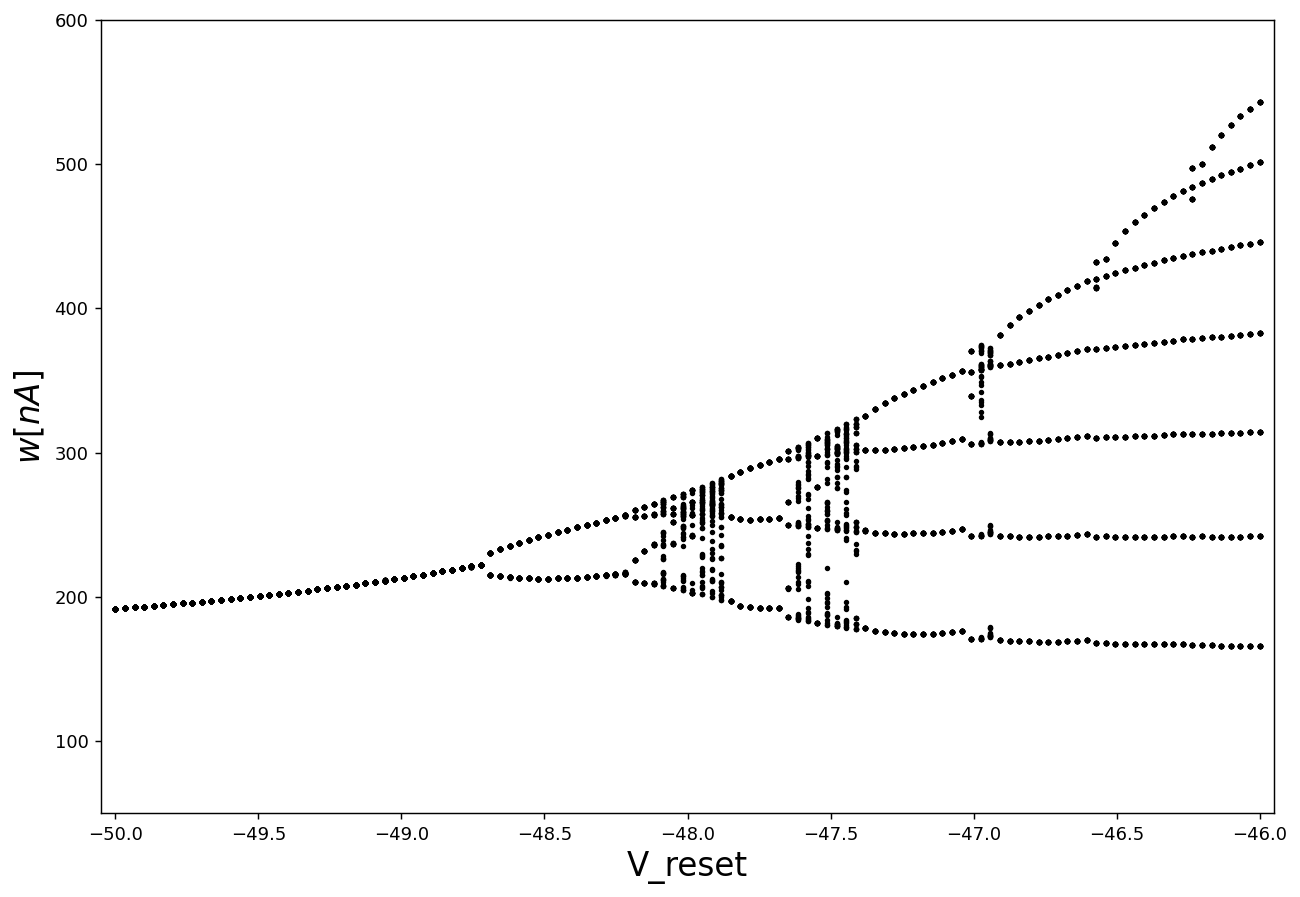

In [9]:
#V_reset bifurcation diagram
#WARNING: LOW RESOLUTION
params = get_params('chaos2')
bifurcation_parameter='V_reset'
bifurcation_range=[-50,-46]
bifurcation_values = np.linspace(bifurcation_range[0], bifurcation_range[1], 120)

plot_bifurcation_diagram(bifurcation_parameter, bifurcation_values, time_span, initial_values, params, xlim=bifurcation_range)

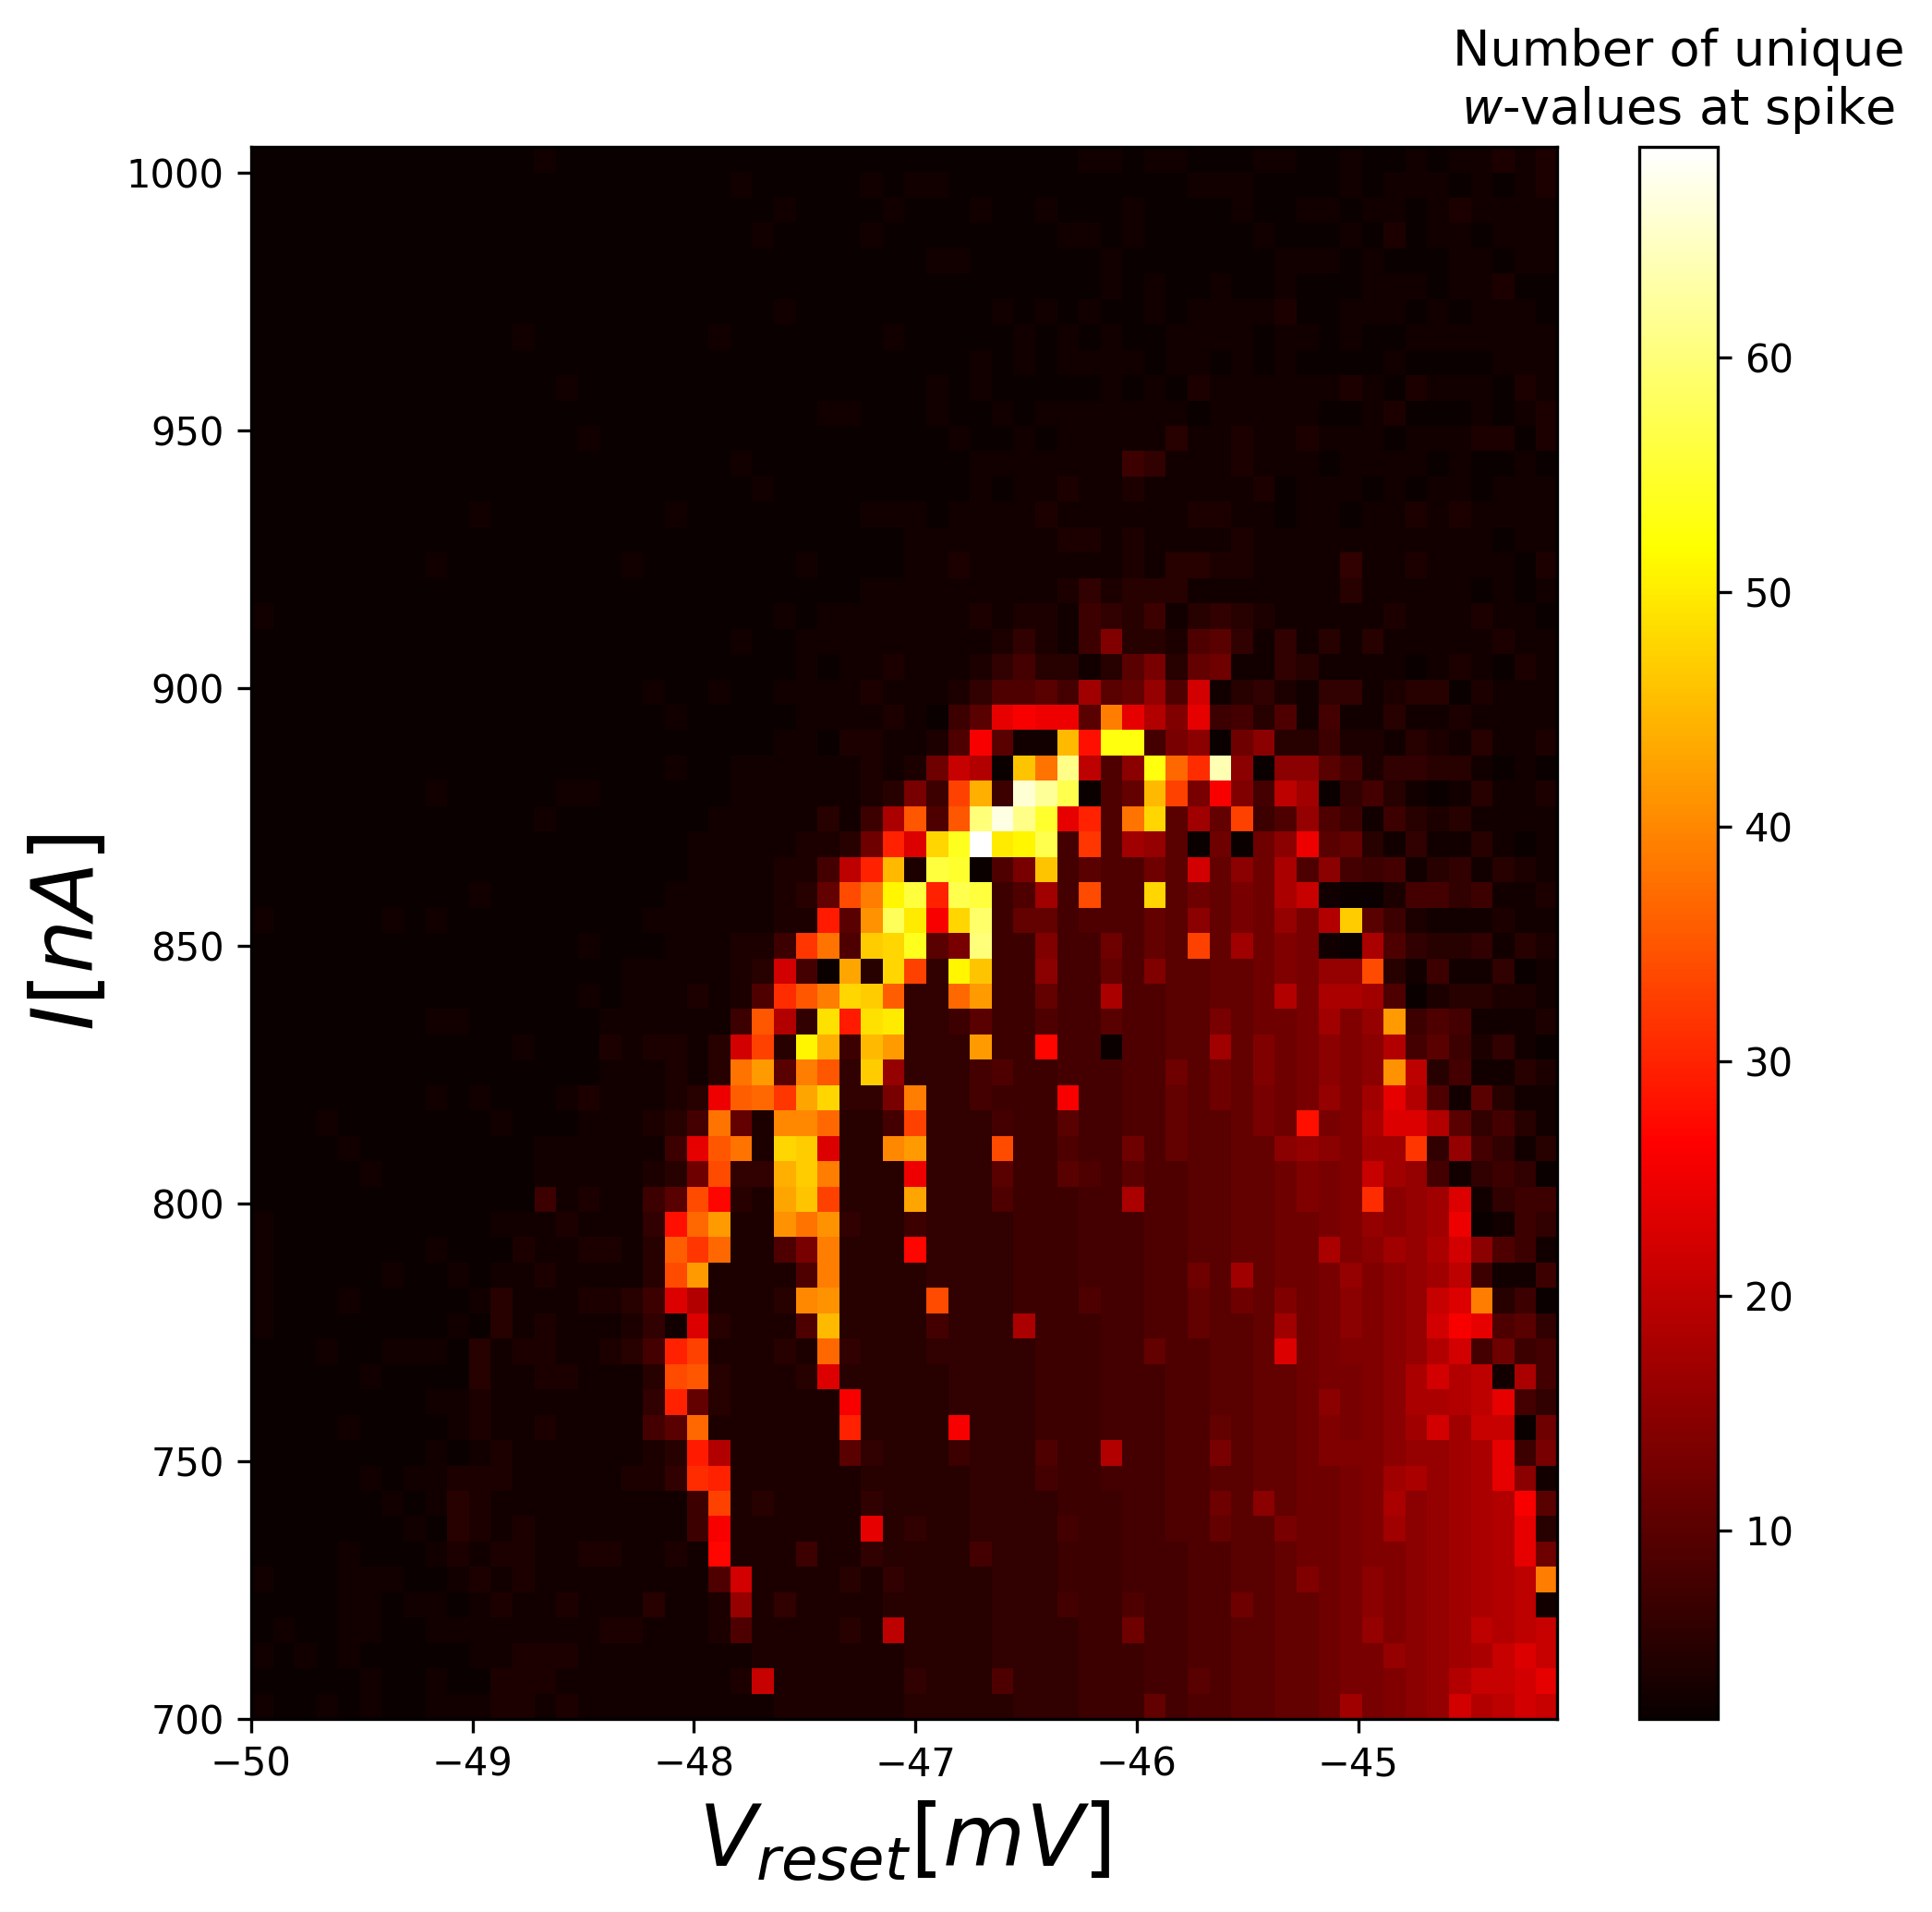

In [10]:
#2D Chaos map
#WARNING: LOW RESOLUTION. To get a higher resolution image, consider more values in I_values_2d and V_reset_values_2d
I_values_2d = np.arange(700, 1000 + 10, 5)
V_reset_values_2d = np.arange(-50, -44, 0.1)
two_dimensional_chaos(time_span, initial_values, params, I_values_2d, V_reset_values_2d)